<center>
<!--img src="./img/ods_stickers.jpg"-->
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 3

### <center> Автор материала: Алексей Борисихин

## <center> Индивидуальный проект по анализу данных </center>
### <center> Прогнозирование осадков по данным почасовых наблюдений в Бразилии </center>

**План исследования**
 - Описание набора данных и признаков
 - Первичный анализ данных
 - Первичный визуальный анализ данных
 - Инсайты, найденные зависимости
 - Выбор метрики
 - Выбор модели
 - Предобработка данных
 - Кросс-валидация и настройка гиперпараметров модели
 - Создание новых признаков и описание этого процесса
 - Построение кривых валидации и обучения
 - Прогноз для тестовой или отложенной выборке
 - Выводы
 
 Более детальное описание <a href="https://github.com/Yorko/mlcourse_open/wiki/3rd-session-in-Russian:-all-activities-accounted-for-in-rating-(in-Russian)#%D0%98%D0%BD%D0%B4%D0%B8%D0%B2%D0%B8%D0%B4%D1%83%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B9-%D0%BF%D1%80%D0%BE%D0%B5%D0%BA%D1%82">тут</a>.

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy import stats

import operator

%matplotlib inline

In [2]:
# import warnings
# warnings.filterwarnings("ignore")

In [3]:
ORIGIANL_DATA_FILE = './../data/project_brazil/sudeste.csv'
PROCESSED_DATA_FILE = './../data/project_brazil/processed.csv'

RANDOM_STATE = 14

###  Часть 1. Описание набора данных и признаков

<p>Имеется набор данных почасовых наблюдений погодных условий от 122 погодных станций Юго-Восточного региона Бразилии. В регион входят штаты: Рио-де-Жанейро, Сан-Паулу, Минас-Жерайс и Эспириту-Санту. Данные собираются с 2000 года (однако не все станции начали работы по сбору именно с этого года). Источником данных является INMET (Национальный Метеорологический Институт - Бразилия). Описание и ссылку на скачивание данных можно найти на странице <a href="https://www.kaggle.com/PROPPG-PPG/hourly-weather-surface-brazil-southeast-region">Kaggle Datasets</a>.

**Описания признаков в датасете**<br><br>
<b>wsid</b> (Numeric) - Уникальный идентификатор погодной станции<br>
<b>wsnm</b> (String) - Наименование погодной станции<br>
<b>elvt</b> (Numeric) - Высота расположения погодной станции<br>
<b>lat</b> (Numeric) - Широта месторасположения погодной станции (град.)<br>
<b>lon</b> (Numericw) - Долгота месторасположения погодной станции (град.)<br>
<b>inme</b> (String) - INMET-код станции для области<br>
<b>city</b> (String) - Город<br>
<b>prov</b> (String) - Штат (провинция)<br>
<b>mdct</b> (DateTime) - Дата и время наблюдения<br>
<b>date</b> (DateTime) - Дата наблюдения<br>
<b>yr</b> (Numeric) - Год наблюдения (2000-2016)<br>
<b>mo</b> (Numeric) - Месяц наблюдения (1-12)<br>
<b>da</b> (Numeric) - День наблюдения (1-31)<br>
<b>hr</b> (Numeric) - Час наблюдения (0-23)<br>
<b>prcp</b> (Numeric) - Количество осадков за последний час (мм)<br>
<b>stp</b> (Numeric) - Давление воздуха (мгновенное) (гПа)<br>
<b>smax</b> (Numeric) - Максимальное давление воздуха за последний час (гПа)<br>
<b>smin</b> (Numeric) - Минимальное давление воздуха за последний час (гПа)<br>
<b>gbrd</b> (String) - Солнечное излучение (кДж/м2)<br>
<b>temp</b> (Numeric) - Температура воздуха (мгновенная) (град. Цельсия)<br>
<b>dewp</b> (Numeric) - Температура точки росы (мгновенная) (град. Цельсия)<br>
<b>tmax</b> (Numeric) - Максимальная температура за последний час (град. Цельсия)<br>
<b>dmax</b> (Numericw) - Максимальная температура точки росы за последний час (град. Цельсия)<br>
<b>tmin</b> (Numeric) - Минимальная температура за последний час (град. Цельсия)<br>
<b>dmin</b> (Numeric) - Минимальная температура точки росыза последний час (град. Цельсия)<br>
<b>hmdy</b> (Numeric) - Относительная влажность (мгновенная) (%)<br>
<b>hmax</b> (Numeric) - Максимальная относительная влажность за последний час (%)<br>
<b>hmin</b> (Numeric) - Минимальная относительная влажность за последний час (%)<br>
<b>wdsp</b> (String) - Скорость ветра (м/с)<br>
<b>wdct</b> (Numeric) - Направление ветра (град) (0-360)<br>
<b>gust</b> (String) - Порывы ветра (м/с)<br>

Данный датасет может быть использован для опробования моделей машинного обучения в области прогнозирования погоды. Явно выделенной целевой переменной нет, а на Kaggle предлагается прогнозировать количество осадков или температуру. Мы попробуем спрогнозировать осадки, т.е. целевой меткой будет являться признак **prcp**. Подробнее последует далее.
<p>Необходимо учесть тот факт, что данные по осадкам хранятся для того часа, для которого актуальны и прочие наблюдения параметров. Для прогнозирования осадков на час, следующий за наблюдаемыми данными, в тренировочном датасете надо выполнить сдвиг значений целевой переменной на один шаг "вперед".
<p>Учитывая, что размер датасета значительный (1.72 Гб), сделаем предобработку файла данных, чтобы не загружать весь датасет в память. В простом предварительном взгляде на данные было выявлено, что примерно в 86% исходных данных отсутствует значение признака **prcp**. Выполним фильтрацию таких данных, оставив для дальнейшего анализа и обработки только корректные.
<p>Также стоит отметить, что, несмотря на присутствие в данных признаков с датой и временем, датасет не стоит расматривать как упорядоченный (какого-то тренда в погоде с течением времени не может быть в такой короткий временной отрезок, как 10-20 лет). Соответственно, эти признаки несут категориальный характер.

In [4]:
%%time

with open(ORIGIANL_DATA_FILE, 'r', encoding='utf-8') as in_file, open(PROCESSED_DATA_FILE, 'w', encoding='utf-8') as out_file:

    total_lines = 0
    processed_lines = 0

    print('Обработано строк:', end=' ', flush=True)

    # read full set
    for line in in_file:

        total_lines += 1

        # write dataset header line
        if total_lines == 1:
            out_file.write(line)
            continue

        # progress indication
        if total_lines % 1000000 == 0:
            print('{}M'.format(total_lines // 1000000), end=' ', flush=True)

        # serch 'prcp' field
        prcp_field = line.split(',')[14]

        if not prcp_field:
            continue
            
        # write line
        processed_lines += 1
        
        out_file.write(line)

    print()
    print('Всего обработано строк (с заголовком): {}'.format(total_lines))
    print('Отфильтрованные строки: {}'.format(processed_lines))

Обработано строк: 1M 2M 3M 4M 5M 6M 7M 8M 9M 
Всего обработано строк (с заголовком): 9779169
Отфильтрованные строки: 1407984
Wall time: 43.4 s


###  Часть 2. Первичный анализ данных

Загрузим предварительно обработанные данные.

In [5]:
df = pd.read_csv(PROCESSED_DATA_FILE)
print('Размер предварительно обработанного датасета: {}'.format(df.shape))

Размер предварительно обработанного датасета: (1407984, 31)


In [6]:
df.head()

,wsid,wsnm,elvt,lat,lon,inme,city,prov,mdct,date,...,tmax,dmax,tmin,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
0,178,SÃO GONÇALO,237.0,-6.835777,-38.311583,A333,São Gonçalo,RJ,2007-11-06 11:00:00,2007-11-06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,178,SÃO GONÇALO,237.0,-6.835777,-38.311583,A333,São Gonçalo,RJ,2007-11-06 12:00:00,2007-11-06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,178,SÃO GONÇALO,237.0,-6.835777,-38.311583,A333,São Gonçalo,RJ,2007-11-06 13:00:00,2007-11-06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,178,SÃO GONÇALO,237.0,-6.835777,-38.311583,A333,São Gonçalo,RJ,2007-11-14 01:00:00,2007-11-14,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,178,SÃO GONÇALO,237.0,-6.835777,-38.311583,A333,São Gonçalo,RJ,2007-11-14 02:00:00,2007-11-14,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


---

Посмотрим на основную информацию о датасете.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1407984 entries, 0 to 1407983
Data columns (total 31 columns):
wsid    1407984 non-null int64
wsnm    1407984 non-null object
elvt    1407984 non-null float64
lat     1407984 non-null float64
lon     1407984 non-null float64
inme    1407984 non-null object
city    1407984 non-null object
prov    1407984 non-null object
mdct    1407984 non-null object
date    1407984 non-null object
yr      1407984 non-null int64
mo      1407984 non-null int64
da      1407984 non-null int64
hr      1407984 non-null int64
prcp    1407984 non-null float64
stp     1407984 non-null float64
smax    1407984 non-null float64
smin    1407984 non-null float64
gbrd    768612 non-null float64
temp    1407983 non-null float64
dewp    1407973 non-null float64
tmax    1407984 non-null float64
dmax    1407965 non-null float64
tmin    1407981 non-null float64
dmin    1407968 non-null float64
hmdy    1407984 non-null float64
hmax    1407980 non-null float64
hmin    14079

---

Посмотрим на характеристики распределения категориальных признаков. Сразу приведем целочисленные признаки **wsid, yr, mo, da, hr** (которые являются категориальными) к строковому типу для корректной обработки методом describe().

In [8]:
int_features = ['wsid', 'yr', 'mo', 'da', 'hr']

for feat in int_features:
    df[feat] = df[feat].astype('str')
    
df.describe(exclude=['float64']).T

,count,unique,top,freq
wsid,1407984,122,418,48024
wsnm,1407984,122,MOELA,48024
inme,1407984,121,ZZZ3,48024
city,1407984,117,Rio de Janeiro,59186
prov,1407984,4,MG,526450
mdct,1407984,129258,2013-06-25 18:00:00,111
date,1407984,5680,2012-01-01,1481
yr,1407984,17,2011,143598
mo,1407984,12,1,167669
da,1407984,31,16,49439


<p>В выборке представлены 4 провинции и 177 городов. Аномальных значений в дате и времени нет. По описанию и практически совпадающим числам уникальных значений признаков **wsid**, **wsnm** и **inme** можно предположить, что данные признаки дублируют друг друга. Проверим это предположение.
<p>Идея состоит в следующем. Используя метод *groupby()*, можно сгруппировать значения одного признака по уникальным значениям другого. Затем с помощью метода *describe()* можно посмотреть на число уникальных значений второго признака в группах. Если на всех позициях стоят единицы, то можно утверждать о полном соответствии в значениях двух признаков.

In [9]:
wsid_groupedby_wsnm_descr = df.groupby('wsnm')['wsid'].describe()
wsid_wsnm_non_unique = wsid_groupedby_wsnm_descr[wsid_groupedby_wsnm_descr['unique'] != 1].shape[0]
print('Число несоответствий между признаками wsid и wsnm: {}'.format(wsid_wsnm_non_unique))

wsid_groupedby_inme_descr = df.groupby('inme')['wsid'].describe()
wsid_inme_non_unique = wsid_groupedby_inme_descr[wsid_groupedby_inme_descr['unique'] != 1].shape[0]
print('Число несоответствий между признаками wsid и inme: {}'.format(wsid_inme_non_unique))

Число несоответствий между признаками wsid и wsnm: 0
Число несоответствий между признаками wsid и inme: 1


Рассмотрим несоответствие детальней. Найдем значение **inme** той станции, по которой происходят расхождения, и посмотрим на уникальные значения координат, соответствующие ей.

In [10]:
non_unique_inme = wsid_groupedby_inme_descr[wsid_groupedby_inme_descr['unique'] != 1].index[0]

print(df[df['inme'] == non_unique_inme]['lat'].value_counts())
print()
print(df[df['inme'] == non_unique_inme]['lon'].value_counts())

-22.041647    18664
Name: lat, dtype: int64

-41.051871    18664
Name: lon, dtype: int64


Видно, что координаты этой проблемной станции принимают во всем датасете лишь одно значение. Значит, предположение о дублировании друг друга признаками **wsid, wsnm, inme** оказывается верным.

---

Выделим вещественные признаки и посмотрим на характеристики их распределения.

In [11]:
df.describe(include=['float64']).T

,count,mean,std,min,25%,50%,75%,max
elvt,1407984.0,593.423665,451.779265,0.000000,189.000000,573.000000,875.000000,1758.000
lat,1407984.0,-20.163774,4.593603,-24.962819,-22.589806,-21.338432,-19.532768,0.000
lon,1407984.0,-43.647082,8.730950,-56.677323,-47.585552,-44.835600,-42.622413,0.000
prcp,1407984.0,0.936654,2.923291,0.000000,0.000000,0.000000,0.600000,100.000
stp,1407984.0,525.744524,471.432826,0.000000,0.000000,895.100000,949.800000,1049.900
smax,1407984.0,525.155668,471.643990,0.000000,0.000000,895.100000,950.000000,1049.900
smin,1407984.0,524.825494,471.337439,0.000000,0.000000,894.400000,949.400000,1050.000
gbrd,768612.0,342.264637,669.663507,0.000000,0.000000,0.210000,375.053250,5552.683
temp,1407983.0,11.309906,10.461438,-3.400000,0.000000,15.700000,20.800000,41.000
dewp,1407973.0,9.886877,9.264952,-10.000000,0.000000,13.500000,18.800000,37.400


Можно сделать предварительные выводы по признакам:<br>
- **elvt** (высота) - значения характеристик скорее всего не содержат выбросов из-за ошибок измерений, или их число мало; возможно сделать проверку, используя геосервисы.
- **lat, lon** (координаты) - присутствуют выбросы в виде нулевых значений координат (все указанные в выборке регионы не паресекаются экватором или нулевым меридианом)
- **prcp** (осадки, целевой признак) - хочется верить, что ошибок измерений нет, иначе у нас вопросы к разметке данных; более 50% данных содержат информацию об отсутствии осадков, а 75% - об отсутствии или незначительных осадках
- **stp, smax, smin** (показатели давления) - явно просматриваются выбросы из-за ошибок измерений в виде нулевых значений, причем их более 25%
- **gbrd** (солнечное излучение) - с этим признакам вообще все плохо. Почти 50% в выборке у этого признака - пропуски. У оставшихся значений более 50% данных содержат нулевые или близкие к нулю выбросы. Выбросы также наблюдаются в виде максимальных значений, в 6 раз превышающих средний показатель солнечного излучения для жарких пустынных мест (ссылки на справочные источники информации будут даны в конце исследования)
- **temp, dewp, tmax, dmax, tmin, dmin** (температурные показатели) - значения скорее всего не содержат значительного числа ошибок измерений
- **hmdy, hmax, hmin** (показатели влажности) - более 25% данных содержат ошибки измерений в виде нулевых значений
- **wdsp, wdct, gust** (показатели ветра) - значения скорее всего не содержат значительного числа ошибок измерений

---

Посомтрим на количество пропусков данных для признаков и отобразим их в порядке убывания.

In [12]:
null_counts = df.isnull().sum()
null_counts[null_counts != 0].sort_values(ascending=False)

gbrd    639372
wdsp     72563
gust     22082
dmax        19
hmin        17
dmin        16
dewp        11
hmax         4
tmin         3
temp         1
dtype: int64

---

Из описания датасета можно увидеть, что признаки **mdct** (дата и время наблюдения) и **date** (дата наблюдения) избыточны, их полностью заменяют следующие признаки: **date, yr, mo, da, hr** (дата, год, месяц, день, час соответственно). Сконвертируем тип признаков **mdct** и **date** во внутренний тип pandas.datetime и проверим, что значения этих признаков соответствуют друг другу.

In [13]:
df['mdct'] = df['mdct'].apply(pd.to_datetime)
df['date'] = df['date'].apply(pd.to_datetime)

In [14]:
def datetime_accordance_check(row):
    return ((row['yr'] == row['mdct'].year) & (row['yr'] == row['date'].year) & 
            (row['mo'] == row['mdct'].month) & (row['mo'] == row['date'].month) & 
            (row['da'] == row['mdct'].day) & (row['da'] == row['date'].day) & 
            (row['hr'] == row['mdct'].hour))

df.apply(datetime_accordance_check, axis=1).value_counts()

False    1407984
dtype: int64

Видим, что рассматриваемые признаки полностью соответствуют друг другу. Избыточные признаки можно будет удалить из датасета.

---

Рассмотрим корреляцию вещественных признаков, исключая целевой. Отобразим распределение и топ-20 коррелирующих пар признаков по двум методам: Пирсона и Спирмана (оценивающие силу линейной и монотонной взаимосвязей соответственно).

In [15]:
numeric_columns = [col for col in df if (df[col].dtype == 'float64')]

pearson_corr = df[numeric_columns].corr(method='pearson')
spearman_corr = df[numeric_columns].corr(method='spearman')

In [16]:
no_target_unique_pearson_corr = dict()
no_target_unique_spearman_corr = dict()

for (row, r_name) in enumerate(pearson_corr.index):
    for (col, c_name) in enumerate(pearson_corr.columns[row+1:]):
        if('prcp' in [r_name, c_name]):
            continue
        no_target_unique_pearson_corr['{}-{}'.format(r_name, c_name)] = abs(pearson_corr.iloc[row, col])
        
for (row, r_name) in enumerate(spearman_corr.index):
    for (col, c_name) in enumerate(spearman_corr.columns[row+1:]):
        if('prcp' in [r_name, c_name]):
            continue
        no_target_unique_spearman_corr['{}-{}'.format(r_name, c_name)] = abs(spearman_corr.iloc[row, col])

pearson_corr_df = pd.DataFrame(sorted(no_target_unique_pearson_corr.items(), key=operator.itemgetter(1), reverse=True))
pearson_corr_df.columns = ['', 'pearson corr']

spearman_corr_df = pd.DataFrame(sorted(no_target_unique_spearman_corr.items(), key=operator.itemgetter(1), reverse=True))
spearman_corr_df.columns = ['', 'spearman corr']

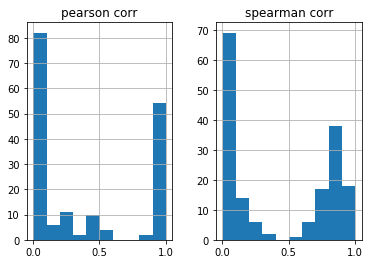

In [17]:
corr_df = pd.concat([pearson_corr_df, spearman_corr_df], axis=1)
corr_df.hist()
plt.show()

In [18]:
corr_df = pd.concat([pearson_corr_df.head(20), spearman_corr_df.head(20)], axis=1)
corr_df

,,pearson corr,,spearman corr
0,elvt-lat,1.000000,elvt-lat,1.000000
1,lon-smax,1.000000,lon-smax,1.000000
2,stp-dewp,1.000000,stp-dewp,1.000000
3,smax-dmax,1.000000,smax-dmax,1.000000
4,smin-dmin,1.000000,smin-dmin,1.000000
5,gbrd-hmax,1.000000,gbrd-hmax,1.000000
6,temp-wdsp,1.000000,temp-wdsp,1.000000
7,dewp-gust,1.000000,dewp-gust,1.000000
8,smax-tmin,0.999967,smax-tmin,0.999931
9,smin-tmin,0.999967,smin-tmin,0.999931


Видим, что оба метода на топ-результатах дают очень схожие показатели. Можно предположить, что корреляция между этими признаками есть, и взаимосвязь линейна. Но зависимость не объясняется физической природой признаков.

---

Рассмотри корреляцию с целевым признаком.

In [19]:
target_pearson_corr = dict(pearson_corr.apply(abs).loc['prcp', :])
target_pearson_corr.pop('prcp')

target_spearman_corr = dict(spearman_corr.apply(abs).loc['prcp', :])
target_spearman_corr.pop('prcp')

target_pearson_corr_df = pd.DataFrame(sorted(target_pearson_corr.items(), key=operator.itemgetter(1), reverse=True))
target_pearson_corr_df.columns = ['', 'pearson corr']

target_spearman_corr_df = pd.DataFrame(sorted(target_spearman_corr.items(), key=operator.itemgetter(1), reverse=True))
target_spearman_corr_df.columns = ['', 'spearman corr']

In [20]:
target_corr_df = pd.concat([target_pearson_corr_df, target_spearman_corr_df], axis=1)
target_corr_df

,,pearson corr,,spearman corr
0,gust,0.382044,hmdy,0.796693
1,hmdy,0.305894,hmax,0.794980
2,hmax,0.303327,hmin,0.769132
3,dmax,0.301448,gust,0.761979
4,dewp,0.296092,wdsp,0.745568
5,dmin,0.292986,dewp,0.745378
6,tmax,0.287871,dmin,0.744746
7,hmin,0.282092,dmax,0.744268
8,smax,0.278865,wdct,0.712490
9,smin,0.278684,smax,0.683713


Тут мы уже не наблюдаем схожесть в значениях коэффициентов корреляции. На оценку по методу Пирсона скорее всего повлияла ненормальность распределения, а по методу Спирмана вероятно, что оценки завышены. В любом случае, можно говорить о некоторой монотонной зависимости целевого признака от ряда других, некоторые объясняются физической природой признаков (например, осадки от влажности и точки росы).

---

Наконец, посмотрим на распределение целевого признака. Построим график в разных масштабах оси ординат.

C:\Users\a.borisihin\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


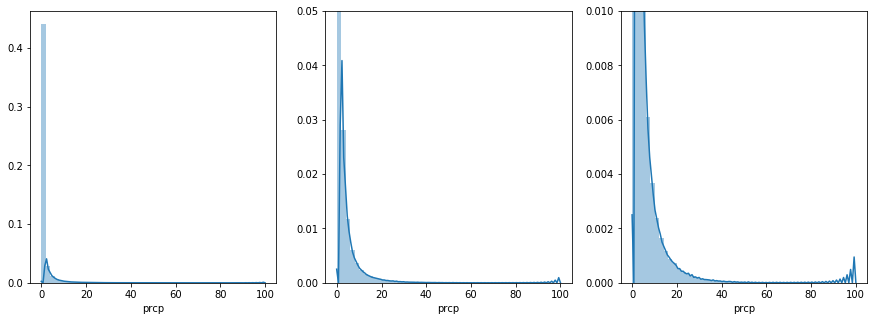

In [21]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

sns.distplot(df['prcp'], ax=axes[0])

sns.distplot(df['prcp'], ax=axes[1])
axes[1].set_ylim(0, 0.05)

sns.distplot(df['prcp'], ax=axes[2])
axes[2].set_ylim(0, 0.01)

plt.show()

Очевидно, что распределение целевого признака далеко от номрального. Тем не менее, проведем статистические тесты на нормальность и скошенность распределения. Для оценки критерия Шапиро-Уилка в модуле scipy.stats существует метод shapiro(). У него есть ограничение на размер выборки - 5000 (в документации указано, что при выборках большего размера точность p-value не гарантируется). Проведем 10 случайных взятий подвыборки заданного размера и найдем среднее значение p-value на этих разбиениях.

In [22]:
shapiro_p_values = []

for split_num in range(10):
    np.random.seed(RANDOM_STATE + split_num)
    rand_split = np.random.randint(0, df.shape[0], size=5000)
    shapiro_p_values.append(stats.shapiro(df.loc[rand_split, 'prcp'])[1])
    
print('Среднее значение p-value критерия Шапиро-Уилка на случайных разбиениях: {}'.format(np.mean(shapiro_p_values)))
print('Значение p-value теста на скошенность распределения: {}'.format(stats.skewtest(df['prcp'])[1]))

Среднее значение p-value критерия Шапиро-Уилка на случайных разбиениях: 0.0
Значение p-value теста на скошенность распределения: 0.0


Полученное среднее p-value критерия Шапиро-Уилка меньше уровня значимости в 0.05, значит распределение не нормальное. Тест на скошенность распределения также не прошел.

Посмотрим внимательней на правый "хвост" распределения.

In [23]:
df[df['prcp'] > 75]['prcp'].value_counts().iloc[-25:]

78.4     3
77.6     2
76.2     2
77.8     1
81.2     1
79.8     1
85.4     1
75.8     1
96.8     1
75.2     1
77.0     1
89.0     1
100.0    1
Name: prcp, dtype: int64

Осадки интенсивностью в районе 100 мм/час - это очень сильные ливни. И хоть такие наблюдения значимы, но их слишком мало в общей массе для какого-то вклада в модель. Выполним фильтрацию нашей целевой переменной по 99% квантилю, чтобы избавиться от таких экстремальных единичных значений.

C:\Users\a.borisihin\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


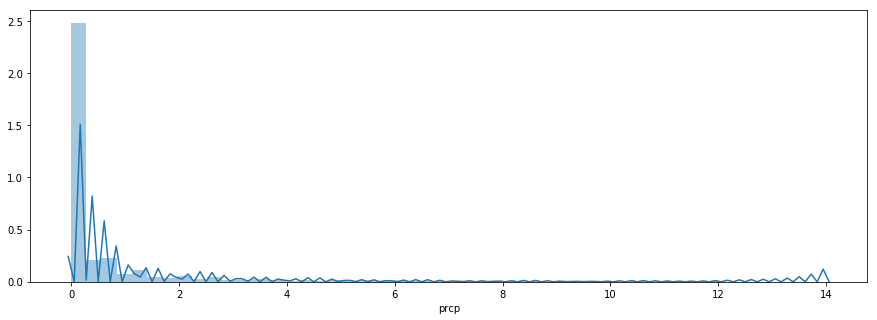

In [24]:
prcp_quantile = df['prcp'].quantile(0.99)
prcp_filtered = df[df['prcp'] < prcp_quantile]['prcp']

plt.figure(figsize=(15, 5))
sns.distplot(prcp_filtered)

<p>После фильтрации по квантилю обнаружилась следующая особенность целевого признака - он принимает дискретные значения (видимо, связанные с ограничениями на измерения в погодных станциях). 
<p>Учитывая все эти факты, принимаем решение перейти от казалось бы предполагаемой задачи регрессии к задаче многоклассовой классификации. Подчерпнув информацию о принятой классификации интенсивности дождей (точнее, об отсутствии единой таковой), выделим "на глаз" следующие классы целевой переменной.
- Отсутствие осадков: $prcp = 0.0$
- Небольшой дождь: $prcp\in(0.0; 1.2]$
- Умеренный дождь: $prcp\in(1.2; 2.5]$
- Сильный дождь: $prcp > 2.5$

###  Часть 3. Первичный визуальный анализ данных

Начнем визуальный анализ с подгруппы категориальных признаков, отражающих временные характеристики: **yr, mo, da, hr**. Построим гистограммы распределений.

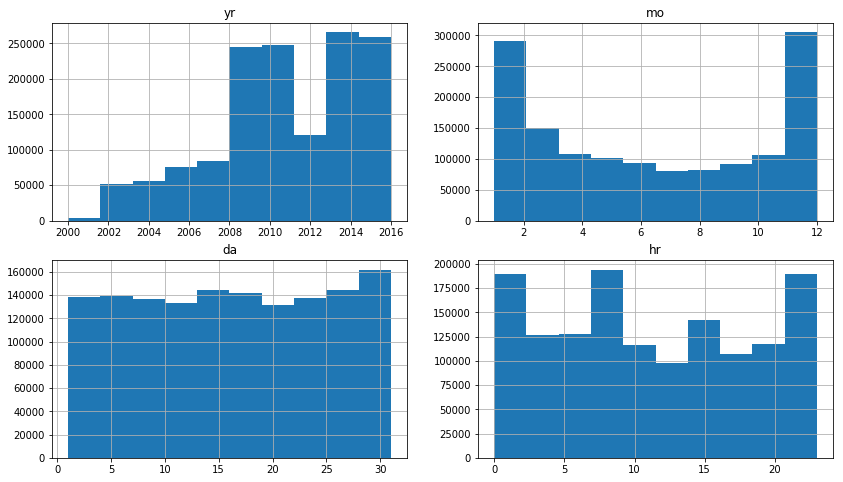

In [25]:
# переведем тип обратно из str
int_features = ['wsid', 'yr', 'mo', 'da', 'hr']
for feat in int_features:
    df[feat] = df[feat].astype('int64')

time_features = ['yr', 'mo', 'da', 'hr']

_, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))

for feat_idx, feat in enumerate(time_features):
    ax = axes[feat_idx // 2, feat_idx % 2]
    df[feat].hist(ax=ax)
    ax.set_title(feat)

Видны следующие факты:
- количество измерений на погодных станциях резко возросло в 2008 году
- в зимние (напомним, что в южном полушарии зима длится с июня по август) месяцы количество измерений сильно меньше, чем в летние

Построим графики зависимости среднего числа осадков от года и месяца

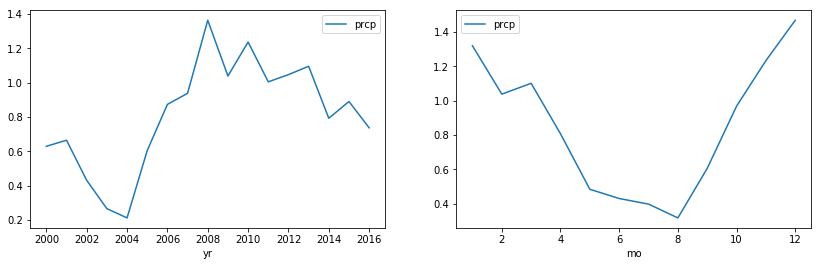

In [26]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

df[['prcp', 'yr']].groupby('yr').mean().plot(ax=axes[0])
df[['prcp', 'mo']].groupby('mo').mean().plot(ax=axes[1])

Видны следующие факты:
- встречаются как засушливые, так и дождливые года
- в летние месяцы среднее число осадков меньше, чем в зимние

---

Посмотрим на распределение данных по погодным станциям. В первичном анализе данных мы выяснили, что три варианта идентификаторов станций (**wsid, wsnm, inme**) дублируют друг друга. Будем испольовать признак **wsid**, как целочисленный.

Уникальные занчения признака wsid: [178 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317 318 319
 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334 335 336 337
 338 339 340 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355
 356 357 358 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373
 374 375 376 377 378 379 380 381 382 383 384 385 386 387 388 389 390 391
 392 393 394 395 396 397 398 399 400 401 402 403 404 405 406 407 408 409
 410 411 412 413 414 415 416 417 418 419 420 421 422 423]


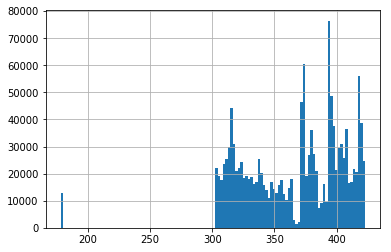

In [27]:
wsid_int = df['wsid'].astype('int64')
print('Уникальные занчения признака wsid: {}'.format(np.unique(wsid_int)))

wsid_int.hist(bins=len(np.unique(wsid_int)))

Количество данных от разных станций в датасете сильно разнится.

---

Рассмотрим теперь вещественные признаки. Из первичного анализа данных мы знаем, что в ряде этих признаков присутствуют пропуски. Заполним их соответствующими средними значениями.

In [28]:
real_features = [feat for feat in df if (df[feat].dtype == 'float64')]
real_features = list(set(real_features) - {'lat', 'lon', 'prcp'})

df_real_features = df[real_features].copy()
df_real_features.fillna(df_real_features.mean(), inplace=True)

Построим гистограммы распределений и "ящики с усами".

C:\Users\a.borisihin\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


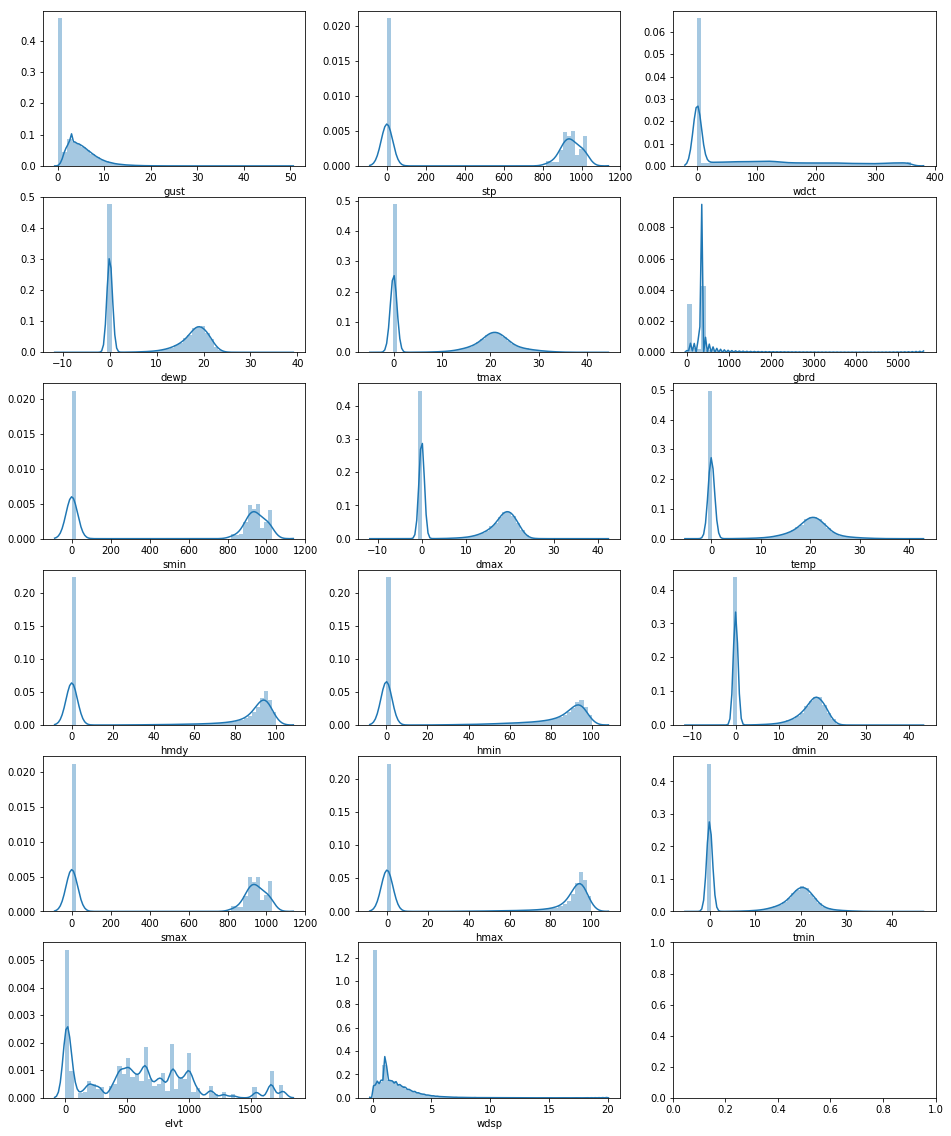

In [29]:
_, axes = plt.subplots(nrows=6, ncols=3, figsize=(16, 20))

for feat_idx, feat in enumerate(df_real_features):
    ax = axes[feat_idx // 3, feat_idx % 3]
    #df_real_features[feat].hist(ax=ax)
    sns.distplot(df_real_features[feat], ax=ax)
    #ax.set_title(feat)

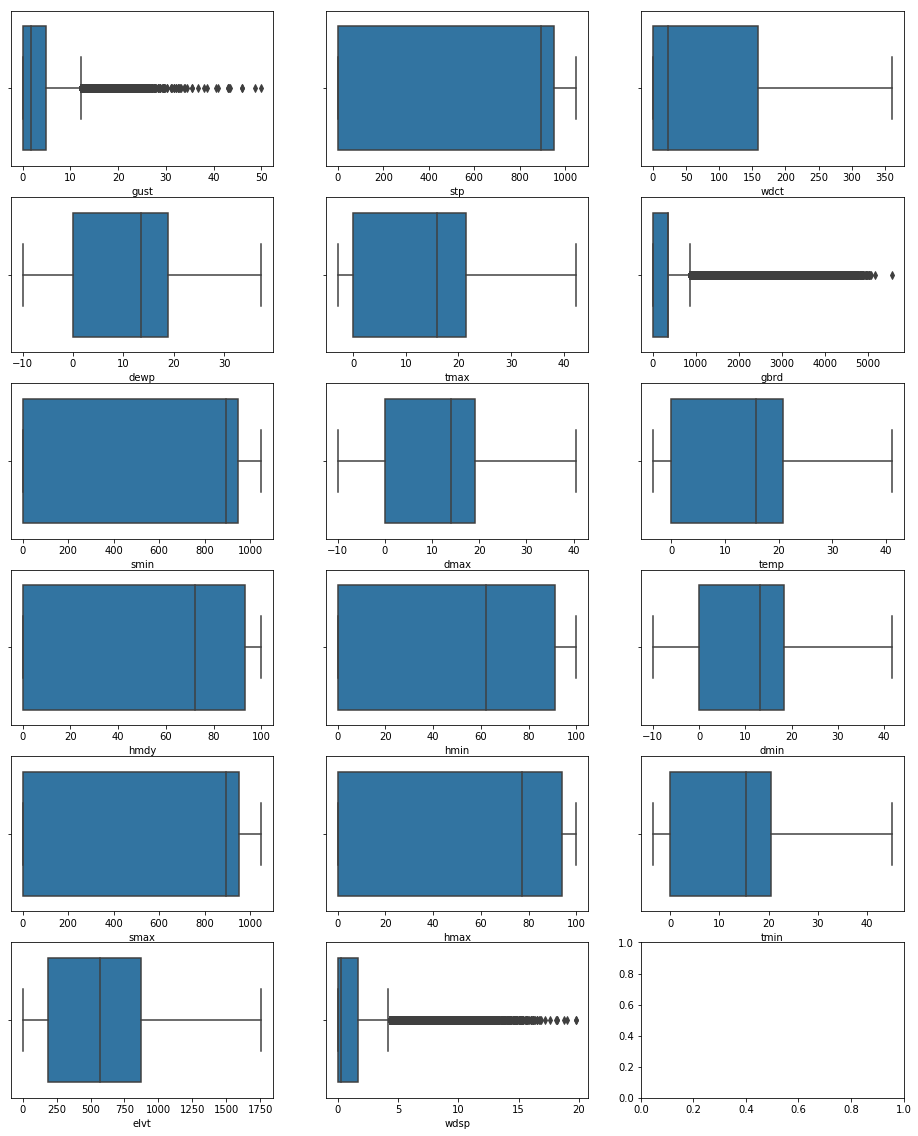

In [30]:
_, axes = plt.subplots(nrows=6, ncols=3, figsize=(16, 20))

for feat_idx, feat in enumerate(df_real_features):
    ax = axes[feat_idx // 3, feat_idx % 3]
    sns.boxplot(df_real_features[feat], ax=ax)

Видны следующие факты:
- как было отмечено в первичном анализе данных, в признаках есть много выбросов с нулевым значением. На гистограммах распределения это видно почти для всех вещественных признаков
- без выбросов большая часть признаков близка к нормальному распределению

---

Рассмотрим теперь графически корреляцию вещественных признаков между собой и с целевым признаком по методу Спирмана.

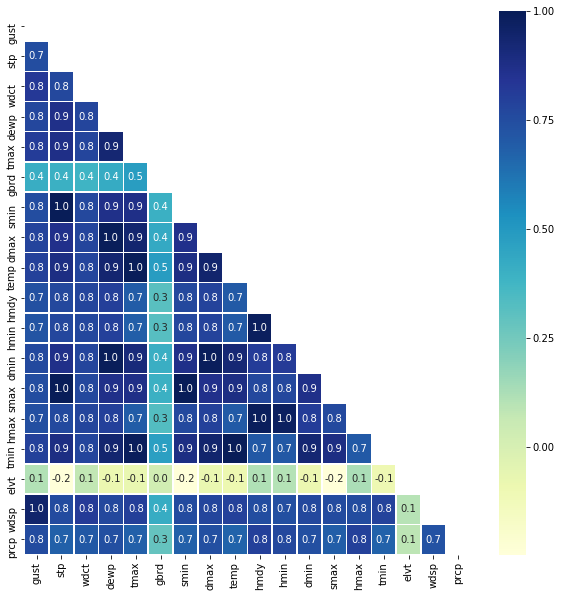

In [31]:
df_real_features_with_target = pd.concat([df_real_features, df['prcp']], axis=1)

corr = df_real_features_with_target.corr(method='spearman')

# маска для отсечения верхнего треугольника корреляционной матрицы
corr_mask = np.zeros_like(corr, dtype=np.bool)
corr_mask[np.triu_indices_from(corr_mask)] = True

plt.figure(figsize=(10, 10))
sns.heatmap(corr, mask=corr_mask, annot=True, fmt='0.1f', linewidths=0.5, cmap='YlGnBu')
plt.show()

Как было отмечено ранее, видна достаточно высокая монотонная корреляция между всеми признаками. Это не очень хорошо, но возможно это связано с большим числом нулевых значений во всех признаках. Также есть признаки, коррелирующие по своей природе. Например, мгновенные, максимальные и минимальные значения какого-то показателя явно будут сильно коррелирующими.

---

Построим графики попарных зависимостей коррелирующих по своей природе признаков. Это мгновенные, минимальные и максимальные значения для: давления, температуры, температуры точки росы, влажности.

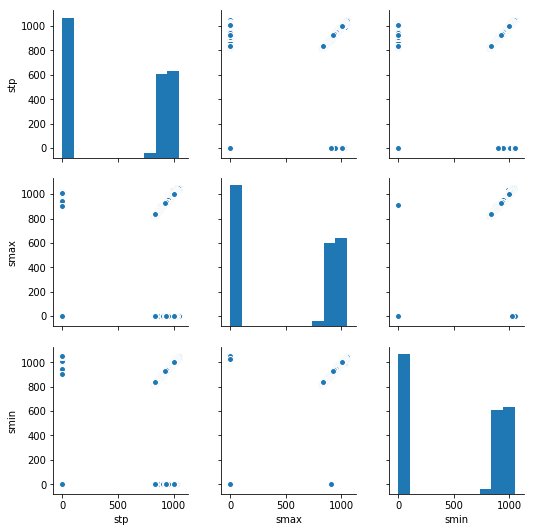

In [32]:
pairplot_features = ['stp', 'smax', 'smin']

sns.pairplot(df_real_features_with_target[pairplot_features])
plt.show()

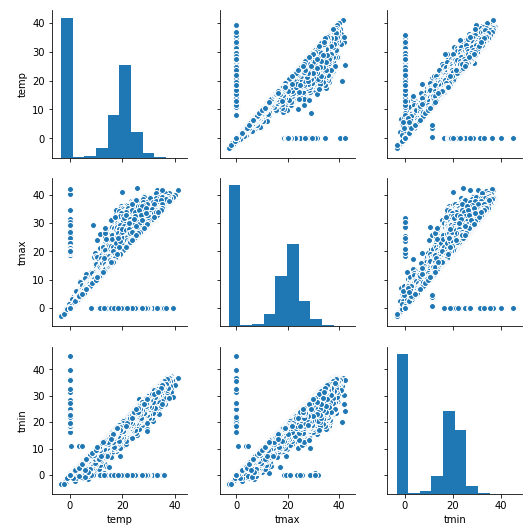

In [33]:
pairplot_features = ['temp', 'tmax', 'tmin']

sns.pairplot(df_real_features_with_target[pairplot_features])
plt.show()

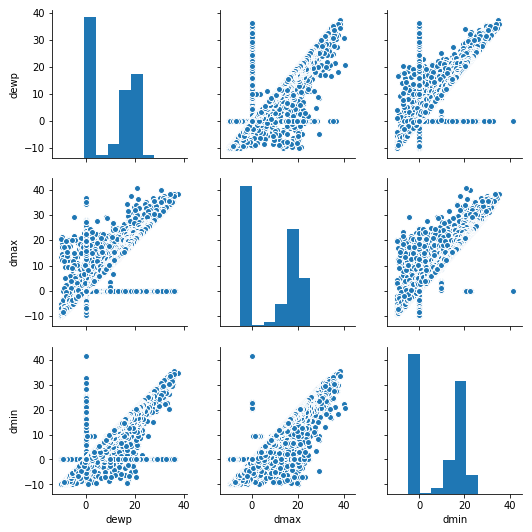

In [34]:
pairplot_features = ['dewp', 'dmax', 'dmin']

sns.pairplot(df_real_features_with_target[pairplot_features])
plt.show()

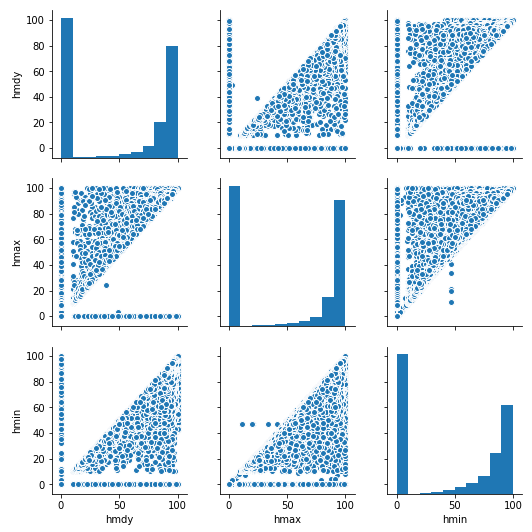

In [35]:
pairplot_features = ['hmdy', 'hmax', 'hmin']

sns.pairplot(df_real_features_with_target[pairplot_features])
plt.show()

Исключая из графиков нулевые выбросы, явно просматривается линейный тренд, для всех групп, кроме значений влажности, как это и обнаружилось в первичном анализе данных.

---

Построим теперь графики попарных зависимостей между целевым признаком и следующими (тут мы исключаем направление ветра и минимальные/максимальные значения температуры, влажности, давления, температуры точки росы): **elvt, stp, gbrd, temp, dewp, hmdy, wdsp, gust**. Для читаемости разделим построение графиков на 2 шага.

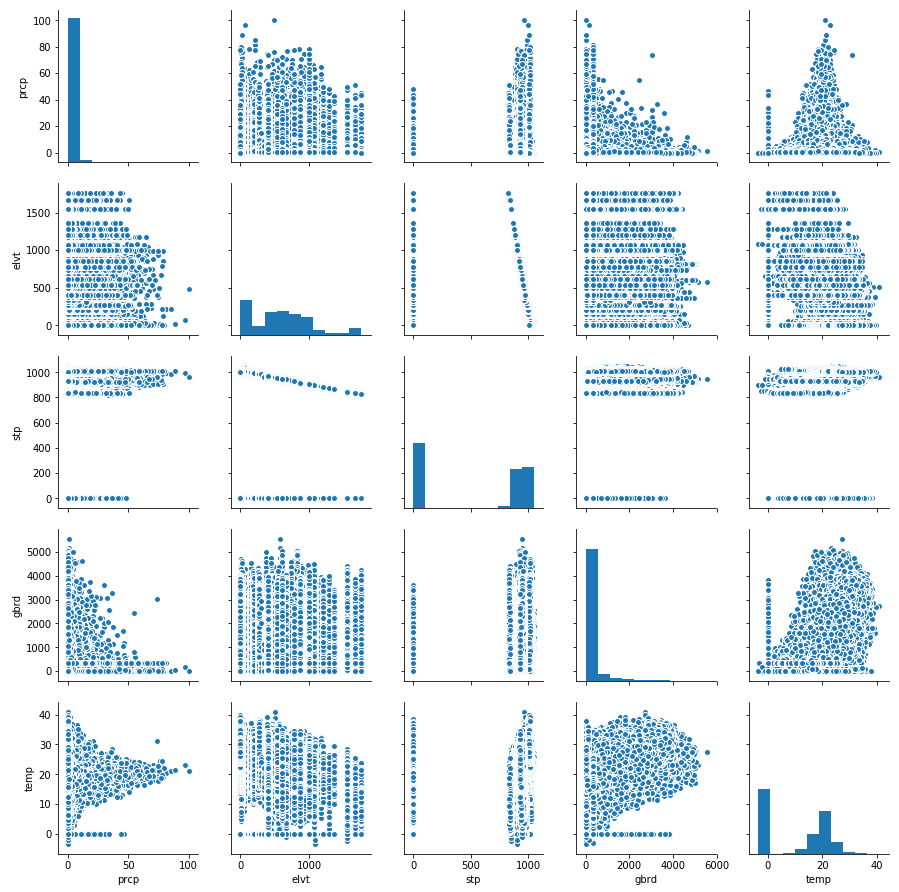

In [36]:
pairplot_features = ['prcp', 'elvt', 'stp', 'gbrd', 'temp']

sns.pairplot(df_real_features_with_target[pairplot_features])
plt.show()

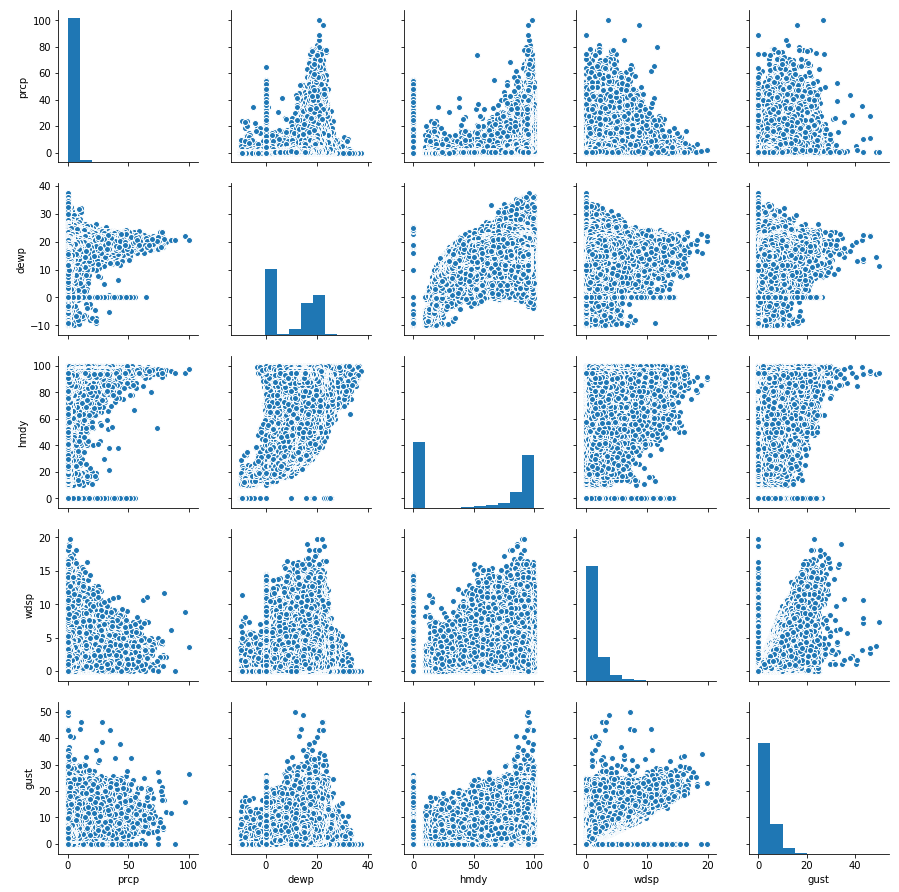

In [37]:
pairplot_features = ['prcp', 'dewp', 'hmdy', 'wdsp', 'gust']

sns.pairplot(df_real_features_with_target[pairplot_features])
plt.show()

Явного линейного тренда не видно ни на одной из попарных зависимостей

###  Часть 4. Инсайты, найденные зависимости

Подводя итог первичному анализу данных, сведем воедино все найденные факты и предположения.

- Необходимо не забывать о способе получения рассматриваемого датасета - из всех доступных исходных данных были отфильтрованы только те записи, в которых не было пропущено значение целевого признака.
- Основная проблема рассматриваемого датасета - большое число выбросов в виде нулевых значений для почти всех признаков. Причем для некоторых признаков это явные выбросы (например, широта с долготой, влажность воздуха), а для других - с первого взгляда это корректные данные (например, температура). При более детальном рассмотрении, идея о корректности данных ставится под сомнение, т.к. слишком высока их доля отосительно других, ненулевых, значений. Скорее всего это связано с особенностью работы погодных станций, которые не измеряют некоторые показатели. 
- Необходим более детальный анализ, который не укладывается в рамки этой работы. Для заполнения выбросов корректными значениями (и, собственно, принятия решения - выброс это, или действительное значение) можно использовать данные находящихся рядом погодных станций. Другой способ - кластеризовать станции по географическим координатам и высоте, для некорректных данных брать средние значения в сходных условиях из кластера.
- Существую две группы в явном виде дублирующих друг друга признаков. Это идентификаторы погодной станции (**wsid, wsnm, inme**) и параметры даты и времени (**mdct, date, yr, mo, da, hr**).
- Из даты и времени есть смысл использовать только месяц как категориальный признак. Засушливость года наврятли окажется полезным признаком для прогноза. А день и час распределены почти равномерно, так что польза их тоже очень сомнительна.
- Существуют три группы линейно коррелирующих признаков. Это мгновенные, минимальные и максимальные значения для: давления воздуха (**stp, smax, smin**), темепратуры воздуха (**temp, tmax, tmin**), температуры точки росы (**dewp, dmax, dmin**).
- Целевой признак (количество осадков) представлен в виде дискретных значений. Сильный скос распределения к нулевым значениям. Учитывая особенности датасета, это могут быть выбросы, как и для других признаков. Но в этом случае наша задача теряет смысл, поэтому остановимся на идее преобладания дней без осадков.
- В данной работе будем учитывать идентификатор погодной станции и координаты сами по себе. Опять же, если выходить за рамки этой работы, то более эффективно было бы выделить географические и высотные кластера погодных станций для более очевидного использования моделями факта о географической близости.

###  Часть 5. Выбор метрики

Для выбора метрики сначала посмотрим на баланс классов целевой переменной. Выведем долю каждого класса.

In [38]:
prcp = df['prcp']

def prcp_transform(val):
    if val == 0.0:
        return 0
    elif (val > 0.0) & (val <= 1.2):
        return 1
    elif (val > 1.2) & (val <=2.5):
        return 2
    elif (val > 2.5):
        return 3
    
prcp = prcp.apply(prcp_transform)

prcp.value_counts(normalize=True)

0    0.530318
1    0.315896
3    0.094195
2    0.059591
Name: prcp, dtype: float64

<p>Можно видеть, что классы сильно несбалансированы. Обычной выбором метрики для задачи классификации с сильным дисбалансом классов является метрика **ROC-AUC**. В отличие от более простых метрик (например, доли верных ответов), ROC-AUC учитывает как TPR (True Positive Rate), так и FPR (False Positive Rate). Значит, она не чувствительна к дисбалансу классов. Также эта метрика позволяет дать оценку качества классификации, основываясь на вероятностых предположениях принадлежности к классу, не привязываяь к какому-то конкретному порогу классификации.
<p>Т.к. классификация в нашей задаче многоклассовая, то необходимо выбрать способ усреднения метрики. После изучения возможных способов в документации sklearn, выберем метод **'macro'** (итоговая оценка метрики усредняется без учета веса класса, что дает более пессимистичную оценку, чем методы 'micro' и 'weighted').

###  Часть 6. Выбор модели

Для нашей задачи будем рассматривать следующие модели:
- **LogisticRegression**. Простая линейная модель, является хорошим бейзлайном в практически любой задачи классификации. Ее линейные коэффициенты также позволят оценить важность того или иного признака в датасете, с помощью L1-регуляризации можно будет избавиться от линейно зависимых признаков. Из минусов - чувствительна к выбросам, что актуально для нашей задачи. Так что не будем ждать от нее хороших результатов.
- **XGBoost**. Характер задачи (относительно небольшое число признаков в масштабах выборки, мало категориальных признаков, которые могут "раздуть" датасет, большое число выбросов, к которым не чувствительны "деревянные" модели) подразумевает, что результат работы градиентного бустинга на деревьях будет одним из лучших среди всех вариантов. Случайный лес, который тоже подходит для описанных условий, оставим без рассмотрения, хотя он тоже мог бы стать хорошим бейзлайном.

###  Часть 7. Предобработка данных

Подготовим датасет для дальнейшей работы моделей. Начнем с целевой переменной. Выполним фильтрацию всего датасета по 99% квантилю целевой перемнной. Выполним сдвиг ее значений на одну позицию вперед, чтобы прогнозировать осадки на час, следующий за наблюдаемым, и выкинем из датасета первую строчку, у которой значение признака **prcp** станет пустым.

In [40]:
prcp_quantile = df['prcp'].quantile(0.99)
df = df[df['prcp'] < prcp_quantile]

df['prcp'] = df['prcp'].shift(1)
df.drop(index=0, inplace=True)

Выполним кодирование значений целевой переменной и выделим ее в отдельный объект.

In [41]:
y = df['prcp'].apply(prcp_transform).astype('int')

Создадим словарь обработанных признаков, для дальнейшего их объединения в итоговый датасет.

In [56]:
processed_features = dict()

<p>Т.к. одной из моделей у нас является линейная, то категориальные признаки нам необходимо закодировать, а численные - отмасштабировать.
<p>Обозначим схему преобразования данных. В нашей задаче у нас отсутствует тестовая выборка, валидацию моделей будем проводить на отложенной части выборки. Но преобразовывать признаки мы будем на всей имеющейся выборке сразу. В общем случае это неправильно, т.к. из валидационной части может "просочиться" информация в обучающую часть (например, учтется масштаб всех значений признаков, будут закодированы все значения категориальных признаков, и т.д.). Мы же закроем глаза на это допущение.

Признак **wsid**. Является категориальным, выполним One-Hot-Encoding с выбрасыванием первой колонки (для того, чтобы не возникало зависимости в новых категориальных признаках). Признаки **wsnm, inme** не используем как дублирующие.

In [57]:
wsid_ohe = pd.get_dummies(df['wsid'], prefix='wsid_ohe', drop_first=True)
processed_features['wsid_ohe'] = wsid_ohe

Признаки **elvt, lat, lon** являются численными, выполним масштабирование.

In [58]:
stnd_scaler = StandardScaler()

elvt_scaled = stnd_scaler.fit_transform(df[['elvt']])
processed_features['elvt_scaled'] = pd.DataFrame(elvt_scaled, columns=['elvt_scaled'])

lat_scaled = stnd_scaler.fit_transform(df[['lat']])
processed_features['lat_scaled'] = pd.DataFrame(lat_scaled, columns=['lat_scaled'])

lon_scaled = stnd_scaler.fit_transform(df[['lon']])
processed_features['lon_scaled'] = pd.DataFrame(lon_scaled, columns=['lon_scaled'])

Признаки **city, prov** не будем использовать в моделях, как малоинформативные (географическую информацию мы уже добавили в виде широты и долготы), но потенциально "раздувающие" датасет (они категориальны и придется кодировать).

Как было обозначено ранее, из признаков даты и времени мы будем использовать только **mo** (месяц). Пояснения см. в п. 4. Несмотря на целочисленность признака, он является конечно же категориальным, так что выполним One-Hot-Encoding.

In [59]:
mo_ohe = pd.get_dummies(df['mo'], prefix='mo_ohe', drop_first=True)
processed_features['mo_ohe'] = mo_ohe

Для **stp, temp, dewp** (давления, температуры воздуха, температуры точки росы) возьмем только мгновенные их значения (максимальные и минимальные значения линейно зависимы, см. п. 4). Воспользуемся масштабированием. Пустые значения заменим средними.

In [60]:
stp_scaled = stnd_scaler.fit_transform(df[['stp']])
processed_features['stp_scaled'] = pd.DataFrame(stp_scaled, columns=['stp_scaled'])

temp_scaled = stnd_scaler.fit_transform(df[['temp']].fillna(df[['temp']].mean()))
processed_features['temp_scaled'] = pd.DataFrame(temp_scaled, columns=['temp_scaled'])

dewp_scaled = stnd_scaler.fit_transform(df[['dewp']].fillna(df[['dewp']].mean()))
processed_features['dewp_scaled'] = pd.DataFrame(dewp_scaled, columns=['dewp_scaled'])

Для **gbrd** (солнечное излучение) заполним пропуски и выполним масштабирование.

In [61]:
gbrd_scaled = stnd_scaler.fit_transform(df[['gbrd']].fillna(df[['gbrd']].mean()))
processed_features['gbrd_scaled'] = pd.DataFrame(gbrd_scaled, columns=['gbrd_scaled'])

Показатели относительной влажности (мгновенная, максимальная и минимальная) используем все, т.к. линейной зависимости в них не наблюдалось, и данные могут быть полезными для прогнозирования осадков. Воспользуемся масштабированием. Пустые значения заменим средними.

In [62]:
hmdy_scaled = stnd_scaler.fit_transform(df[['hmdy']])
processed_features['hmdy_scaled'] = pd.DataFrame(hmdy_scaled, columns=['hmdy_scaled'])

hmin_scaled = stnd_scaler.fit_transform(df[['hmin']].fillna(df[['hmin']].mean()))
processed_features['hmin_scaled'] = pd.DataFrame(hmin_scaled, columns=['hmin_scaled'])

hmax_scaled = stnd_scaler.fit_transform(df[['hmax']].fillna(df[['hmax']].mean()))
processed_features['hmax_scaled'] = pd.DataFrame(hmax_scaled, columns=['hmax_scaled'])

Показатели ветра **wdsp, gust** (скорость, порывы) отмасштабируем и заполним пропуски. Направление ветра **wdct** разобьем на 10-градусные сектора, 36-ой сектор заменим нулевым, и выполним One-Hot-Encoding.

In [63]:
wdsp_scaled = stnd_scaler.fit_transform(df[['wdsp']].fillna(df[['wdsp']].mean()))
processed_features['wdsp_scaled'] = pd.DataFrame(wdsp_scaled, columns=['wdsp_scaled'])

gust_scaled = stnd_scaler.fit_transform(df[['gust']].fillna(df[['gust']].mean()))
processed_features['gust_scaled'] = pd.DataFrame(gust_scaled, columns=['gust_scaled'])

wdct_processed = df['wdct'].fillna(df[['wdct']].mean())
wdct_processed = wdct_processed.apply(lambda x: x // 10).apply(lambda x: x if x != 36.0 else 0.0)
wdct_ohe = pd.get_dummies(wdct_processed, prefix='wdct_ohe', drop_first=True)
processed_features['wdct_ohe'] = wdct_ohe

Наконец, соберем все признаки воедино.

In [64]:
for name_df, part_df in processed_features.items():
    processed_features[name_df] = part_df.reset_index(drop=True)

X = pd.concat(processed_features.values(), axis=1)
print('Размер обработанной выборки: {}'.format(X.shape))

Размер обработанной выборки: (1393614, 179)


Выделим обучающую и валидационную части выборки. Ранее уже упоминалось, что упорядочивание выборки по времени не имеет смысла, так что воспользуемся случайным разбиением и выделим для валидации 30% всей выборки. Укажем параметр stratify для сохранения баланса классов в новых выборках.

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=RANDOM_STATE)

In [66]:
print('Размер обучающей выборки:', X_train.shape)
print('Размер обучающего вектора целевой переменной:', y_train.shape)
print('Размер валидационной выборки:', X_test.shape)
print('Размер валидационного вектора целевой переменной:', y_test.shape)

Размер обучающей выборки: (975529, 179)
Размер обучающего вектора целевой переменной: (975529,)
Размер валидационной выборки: (418085, 179)
Размер валидационного вектора целевой переменной: (418085,)


###  Часть 8. Кросс-валидация и настройка гиперпараметров модели

###  Часть 9. Создание новых признаков и описание этого процесса

###  Часть 10. Построение кривых валидации и обучения

### Часть 11. Прогноз для тестовой или отложенной выборки

### Часть 12. Выводы 

### Ссылки

1. http://meteocenter.net/forecast/comment.htm<br>
Классификация осадков по интенсивности была подобрана "на глаз", основываясь на классификации из статьи.<br>
2. http://www.zodchii.ws/books/info-756.html<br>
"Количество солнечной энергии, поступающей за год на 1 м2 поверхности Земли, изменяется приблизительно от 3000 МДж/м2 на севере до 8000 MДж/м2 в наиболее  жарких пустынных местах"<br>
Что эквивалентно почасовым значениям: 340 кДж/м2 для северных регионов, 910 кДж/м2 для жарких пустынных регионов<br>